# Sliding Mode Control


This discussion on sliding mode control for a multirotor closely follows the work of L'Afflitto et al. [1], in the notation of Khalil [2]. A diagram of the control scheme (taken from [1]) is shown below.

![Control Scheme Diagram](assets/smc_control_scheme.png)

In [1]:
%%capture
# Load the quadrotor simulator from a previous notebook
%run quadsim.ipynb

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

class SMC(Controller):
    """Sliding Mode Controller
    """
    def __init__(self):
        self.name = "SMC"
        
        # estimates of the physical properties of the quadrotor
        self.g = 9.81
        self.mass = 3.81
        Jxx = 0.060224; Jyy = 0.122198; Jzz = 0.132166
        self.I = np.array([[Jxx,0,0],
                           [0,Jyy,0],
                           [0,0,Jzz]])
        
        # proportional control law \phi(\eta) that stabilizes the \dot\eta = f_a system
        self.Keta = 0.01*np.eye(4)
        
    def fa(self, eta, xi):
        return xi
    
    def fb(self, eta, xi):
        # extract omega from xi
        omega = xi[1:4]
        
        r = np.zeros((4,1))
        r[0,0] = self.g
        r[1:4] = -np.linalg.inv(self.I).dot(np.cross(omega, self.I.dot(omega), axis=0))
        return r
        
    def inner(self, state):
        # Transform the system into the form of HK (14.4) and (14.5)
        eta = np.array([state.flatten()[[2, 6, 7, 8]]]).T # r_z, ph, th, ps
        xi = np.array([state.flatten()[[5, 9, 10, 11]]]).T # \dot{r_z}, p, q, r
        
        ph = eta.flatten()[1]
        th = eta.flatten()[2]
        ps = eta.flatten()[3]
        
        # Build the L(x) = inv(G(x)) matrix
        L = np.eye(4)
        L[0, 0] = -self.mass # TODO: should this negative be there? Should there be a rot matrix?
        L[1:4, 1:4] = self.I
        
        ueq = -L.dot(self.fb(eta, xi) + self.Keta.dot(self.fa(eta, xi)))
        
        return ueq
    
    def outer(self):
        pass
    
    def update(self, commanded, state, Ts):
        
        #
        # Outer Loop
        #
        
        #
        # Inner Loop
        #
        u = self.inner(state)
#         print(u[0], u[1], u[2], u[3])
        
        # actuator commands
        return u, commanded

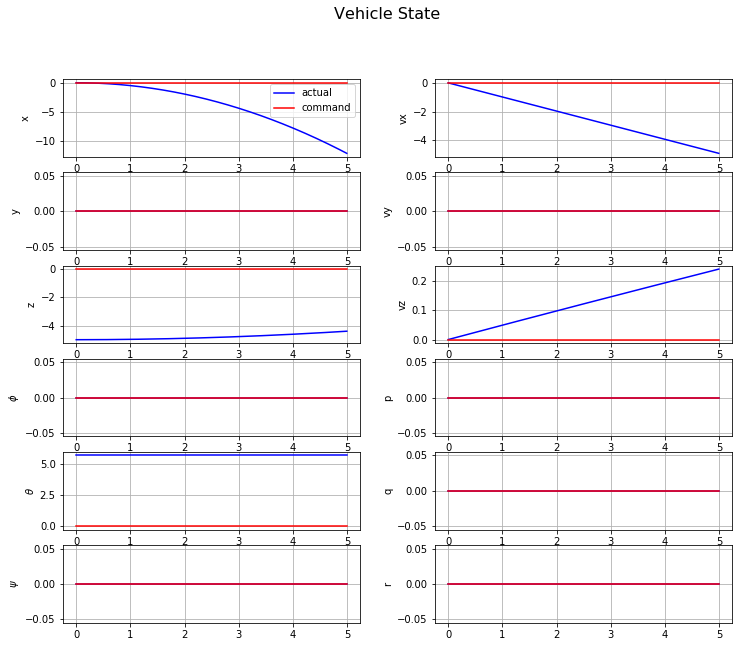

Quadrotor state after 500 iters:
	r:     [[-12.219  0.000 -4.399]].T
	Phi:   [[ 0.000  0.100  0.000]].T
	v:     [[-4.897  0.000  0.239]].T
	omega: [[ 0.000  0.000  0.000]].T



In [3]:
quad = Quadrotor(r=np.array([[0],[0],[-5]]),
                 v=np.array([[0],[0],[0]]),
               Phi=np.array([[0],[0.1],[0]]))
sim = Simulator(quad=quad, ctrl=SMC())
sim.run(5, Ts=0.01)
sim.plot()

print(sim.quad)

## References

[1] A. L’Afflitto, R. Anderson, and K. Mohammadi, “An Introduction to Nonlinear Robust Control for Unmanned Quadrotor Aircraft,” IEEE Control Syst. Mag., vol. 38, no. June, pp. 102–121, 2018.

[2] H. K. Khalil, Nonlinear Systems. Princeton, NJ: Prentice Hall, 2002.